# Probabilistic HO calving model with artificial geometry

Implementation of a simple calving law. Assuming some idealized bed, initial geometry, and surface mass balance, we experiment with the following calving law:

At each timestep, a prospective new terminus is chosen as the longitudinal location at which the effective strain rate attains its largest value. If the effective strain rate exceeds a chosen critical strain rate, $\varepsilon_c$, then a calving event is possible. The likelihood of a calving event driving the terminus back to that location is determined by the fraction above flotation, with

$$p_{calving} = max(f_{af}, f_{min})c\Delta t$$

for some scalaing factor $c$ and some minimum fraction above flotation (which is imposed so that the probability of calving from an ice tongue is nonzero). The factor of $\Delta t$ (the timestep) is included to prevent the calving frequency from depending on the timestep (now a finer timestep will be associated with a lower likelihood of calving in a given step). 

In [1]:
ε_c, faf_min, c = 0.001, 0.01, 10

## Imports

In [2]:
from firedrake import *
import icepack
from icepack.models.hybrid import horizontal_strain_rate, vertical_strain_rate, _effective_strain_rate
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os
import tqdm

os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from centerflow_extruded import *

## Paths

In [3]:
figures_path = '/eejit/home/bezu0001/icepack/figures/HO_calving_probabilistic/'

## Mesh with centerline_extruded

In [4]:
n_cells = 200
length = 10000

mesh = centerline_mesh(n_cells = n_cells, length = length)
x, ζ = SpatialCoordinate(mesh.mesh)
V = FunctionSpace(mesh.mesh, 'CG', 1, vfamily = 'GL', vdegree = 2) #function space for quantities which vary with depth
Q = FunctionSpace(mesh.mesh, 'CG', 1, vfamily = 'R', vdegree = 0)

## Define initial geometry

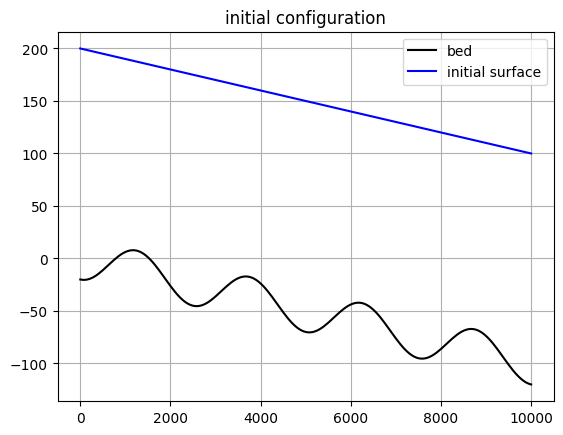

In [5]:
amp = 20      
period = mesh.length/4   
frontal_elevation = -100.0 #elevation of bed at the front (negative below sea level)
slope = -0.01 #underlying bed slope

offset = frontal_elevation - slope*mesh.length
bed_flat  = Function(Q).interpolate(offset + slope*x) #the bed slope downward
bed_bumpy = Function(Q).interpolate(-amp*firedrake.cos(2*np.pi*x/period)) #with some sinusoidal variation superimposed
bed = Function(Q).interpolate(bed_flat + bed_bumpy)

H_0 = Constant(200)
H = Function(Q).project(H_0)
s = Function(Q).project(bed_flat + H_0)
u = Function(V).project(Function(Q).project(Constant(1e-10)))
smb = Constant(0)

plt.figure()
plt.title('initial configuration')
plt.plot(mesh.X, icepack.depth_average(bed).at(mesh.X), color = 'k', label = 'bed')
plt.plot(mesh.X, icepack.depth_average(s).at(mesh.X), color = 'blue', label = 'initial surface')
# plt.ylim(-length/2, length/2)
plt.legend()
plt.grid()

## Initialize solvers

In [6]:
def basal_friction(**kwargs): #function to scale the basal friction by fraction above flotation
    H = kwargs['thickness']
    s = kwargs['surface']
    u = kwargs['velocity']
    C = kwargs['friction']

    b = s - H
    ϱ = icepack.constants.ice_density/icepack.constants.water_density 

    flotation_surface = (1 - ϱ)*H #given the current thickness, this is the hypothetical surface elevation which would float the shelf
    h_af = s - flotation_surface #height above flotation
    frac_af = firedrake.min_value(h_af/H, 1) #fraction above flotation, capped at unity
    
    return icepack.models.hybrid.bed_friction(velocity = u, friction = C*frac_af)

T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))
C = Constant(0.5)

model_opts = {'dirichlet_ids': [1]}
flow_model = icepack.models.HybridModel(friction = basal_friction)
flow_solver = icepack.solvers.FlowSolver(flow_model, **model_opts)

## Spin up to steady state

In [7]:
model_time = 300
Δt = 1/10
num_timesteps = int(model_time/Δt)

for step in trange(num_timesteps):
    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A, friction = C)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H_0, accumulation = smb)
    s = icepack.compute_surface(thickness = H, bed = bed)

base = Function(Q).project(s - H)

u_surf_array = u.at(mesh.surface_coords, tolerance = 1e-10)
u_base_array = u.at(mesh.basal_coords, tolerance = 1e-10)
s_array = icepack.depth_average(s).at(mesh.X, tolerance = 1e-10)
bed_array = icepack.depth_average(bed).at(mesh.X, tolerance = 1e-10)
base_array = icepack.depth_average(base).at(mesh.X, tolerance = 1e-10)

100%|███████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:37<00:00, 30.79it/s]


In [8]:
ϱ = icepack.constants.ice_density/icepack.constants.water_density

H_0 = Constant(H.at(0, 0))
s_0 = s.copy(deepcopy = True)
bed_t = icepack.depth_average(bed).at(mesh.length, tolerance = 1e-10)
x_t = mesh.length

Δx = 1000 #extend the domain to permit advance
mesh_0 = centerline_mesh(mesh = mesh, n_cells = n_cells, extra_length = Δx)
mesh_1 = mesh
bed_0 = extend_to_mesh(function = bed, mesh = mesh_0, ice_free_value = bed_t)

Q = bed.function_space()
bed0_array = np.array(icepack.depth_average(bed_0).at(mesh_0.X, tolerance = 1e-10))
d = Function(Q).project(max_value(-base, 0))
print(f'initial water depth = {d.at(x_t, 0)} m')

events = []
fafs = []
surfaces = []
bases = []
εes = []
εxxs = []
εxzs = []
Xs = []


x_1, x_2 = mesh_0.length - mesh_0.length, mesh_0.length
y_1 = bed_0.at((x_2, 0), tolerance = 1e-10) - 100
y_2 = s_0.at((x_1, 0), tolerance = 1e-10) + 100

initial water depth = 59.372915847398566 m


Text(0.5, 1.0, 'steady state geometry')

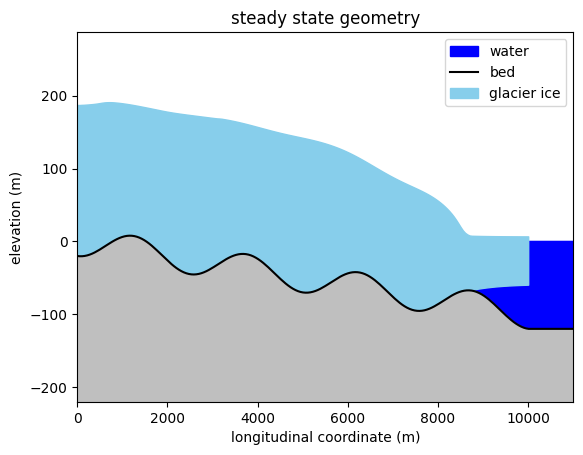

In [9]:
s_array = np.array(icepack.depth_average(s).at(mesh_1.X, tolerance = 1e-10))
base_array = np.array(icepack.depth_average(base).at(mesh_1.X, tolerance = 1e-10))

water_mask = (0 > bed0_array) # & (mesh_0.X > x_t)

plt.figure()
plt.fill_between(mesh_0.X, bed0_array, 0, color = 'blue', where = water_mask, label = 'water')
plt.plot(mesh_0.X, bed0_array, color = 'k', label = 'bed')
plt.fill_between(mesh_1.X, base_array, s_array, color = 'skyblue', label = 'glacier ice')
plt.fill_between(mesh_0.X, y_1, bed0_array, color = '0.75')
plt.legend(loc = 'upper right')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.xlim(x_1, x_2)
plt.ylim(y_1, y_2)
plt.title('steady state geometry')
# plt.grid()

## Run the calving model

In [10]:
model_time = 150
num_timesteps = int(model_time/Δt)

arrays = {name: np.empty(num_timesteps, dtype=object) 
          for name in ['fafs', 'events', 'surfaces', 'bases', 'εes', 'εxxs', 'εxzs', 'Xs']}

for step in trange(num_timesteps):

    flow_model = icepack.models.HybridModel(friction = basal_friction)
    flow_solver = icepack.solvers.FlowSolver(flow_model, **model_opts)

    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A, friction = C)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H_0, accumulation = smb)
    s = icepack.compute_surface(bed = bed, thickness = H)
    base = Function(Q).project(s - H)
    d = Function(Q).project(max_value(-base, 0))

    H_t = H.at(x_t, 0)
    d_t = d.at(x_t, 0)
    u_t = icepack.depth_average(u).at(x_t)
    advance = u_t*Δt

    f_af = max(ϱ*H_t/d_t - 1, faf_min) #fraction above flotation
    arrays['fafs'][step] = f_af

    ε_xx = horizontal_strain_rate(velocity = u, thickness = H, surface = s)
    ε_xz = vertical_strain_rate(velocity = u, thickness = H)
    ε_e =_effective_strain_rate(ε_xx, ε_xz, icepack.constants.strain_rate_min)    
    εe_array = np.array(icepack.depth_average(Function(V).project(ε_e)).at(mesh_1.X, tolerance = 1e-10))
    εxx_array = np.array(icepack.depth_average(Function(V).project(ε_xx)).at(mesh_1.X, tolerance = 1e-10))
    εxz_array = np.array(icepack.depth_average(Function(V).project(ε_xz)).at(mesh_1.X, tolerance = 1e-10))
    arrays['εes'][step] = εe_array
    arrays['εxxs'][step] =εxx_array
    arrays['εxzs'][step] = εxz_array
        
    εe_max = np.max(εe_array)
    x_c = int(np.where(εe_array == εe_max)[0][0])
    calving_front = float(mesh_1.X[x_c])
    
    probability = 1 if step == 50 and np.sum(arrays['events'][:50]) == 0.0 else c*f_af*Δt #force a calving event to kick things off
    
    if np.random.random() < probability and εe_max >= ε_c and d.at(x_c, 0) > 0 and d.at(x_t, 0) > 0:
        Δx = calving_front - mesh_1.length
        arrays['events'][step] = np.abs(Δx) + np.abs(advance) #actual calving event size must account for the forward motion each timestep
    else:
        Δx = advance
        arrays['events'][step] = 0.0 
        
    mesh_2 = centerline_mesh(mesh = mesh_1, n_cells = n_cells, extra_length = Δx)
    x_t = mesh_2.length
    
    H = extend_to_mesh(function = H, mesh = mesh_2, ice_free_value = H_t)
    bed = extend_to_mesh(function = bed_0, mesh = mesh_2)
    s = icepack.compute_surface(bed = bed, thickness = H)
    u = extend_to_mesh(function = u, mesh = mesh_2, ice_free_value = u_t)

    Q = s.function_space()
    V = u.function_space()
    base = Function(Q).project(s - H)

    mesh_1 = mesh_2
    arrays['Xs'][step] = mesh_1.X

    bed_array = np.array(icepack.depth_average(bed).at(mesh_1.X, tolerance = 1e-10))
    s_array = np.array(icepack.depth_average(s).at(mesh_1.X, tolerance = 1e-10))
    arrays['surfaces'][step] = s_array
    H_array = np.array(icepack.depth_average(H).at(mesh_1.X, tolerance = 1e-10))
    base_array = s_array - H_array
    arrays['bases'][step] = base_array

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [37:55<00:00,  2.28s/it]


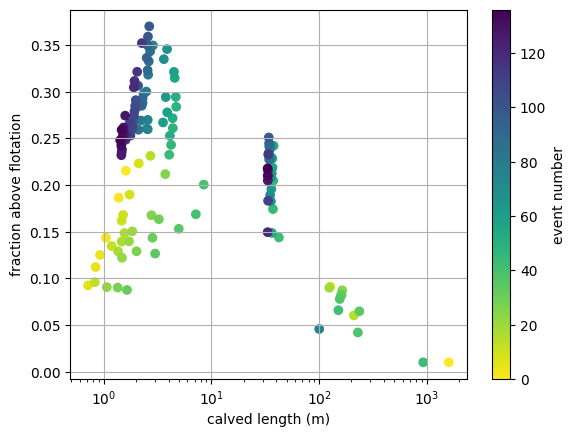

In [25]:
fafs, events = arrays['fafs'], arrays['events']
fafs = fafs[events > 0]
events = events[events > 0]

N = len(events)
steps = np.arange(N)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N-1)
fig, ax = plt.subplots()
sc = ax.scatter(events, fafs, c=steps, cmap=cmap, norm=norm, alpha = 1.0)
ax.set_xscale('log')
ax.grid()
ax.set_xlabel('calved length (m)')
ax.set_ylabel('fraction above flotation')
fig.colorbar(sc, ax=ax, label = 'event number')
plt.show()

## Plot results

100%|███████████████████████████████████████████████████████████████████████████████▉| 999/1000 [04:13<00:00,  4.13it/s]

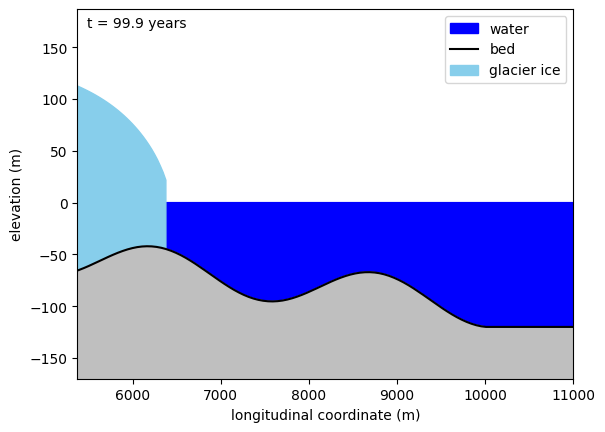

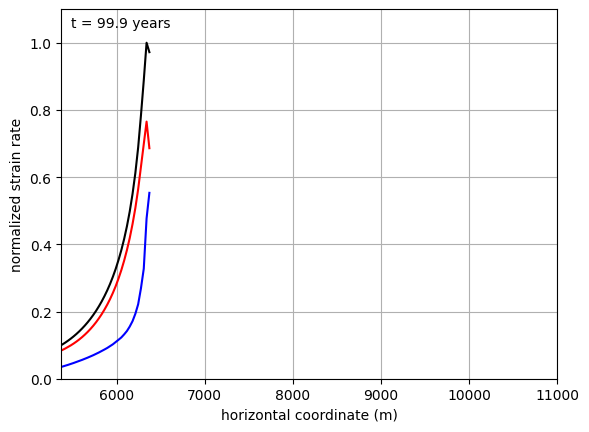

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


In [39]:
x_1, x_2 = mesh_1.length - 1000, mesh_0.length
y_1 = bed_0.at((x_2, 0), tolerance = 1e-10) - 50
y_2 = s_0.at((x_1, 0), tolerance = 1e-10) + 50

for step in trange(num_timesteps):

    base_array = arrays['bases'][step]
    s_array = arrays['surfaces'][step]
    εe_array = arrays['εes'][step]
    εxx_array = arrays['εxxs'][step]
    εxz_array = arrays['εxzs'][step]
    εe_max = np.max(εe_array)
    X = arrays['Xs'][step]
    
    plt.figure()
    plt.fill_between(mesh_0.X, bed0_array, 0, color = 'blue', where = water_mask, label = 'water')
    plt.plot(mesh_0.X, bed0_array, color = 'k', label = 'bed')
    plt.fill_between(X, base_array, s_array, color = 'skyblue', label = 'glacier ice')
    plt.fill_between(mesh_0.X, y_1, bed0_array, color = '0.75')
    plt.legend(loc = 'upper right')
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.xlim(x_1, x_2)
    plt.ylim(y_1, y_2)
    plt.gca().text(0.02, 0.95, f't = {step*Δt:.1f} years', transform=plt.gca().transAxes)
    os.chdir(figures_path + 'profiles')
    plt.savefig(f'profile_{step}') 
    if step < num_timesteps - 1:
        plt.close()
    else:
        plt.show()
    
    plt.figure()
    plt.plot(X, εxx_array/εe_max, color = 'blue', label = 'horizontal strain rate')
    plt.plot(X, εxz_array/εe_max, color = 'red', label = 'vertical strain rate')
    plt.plot(X, εe_array/εe_max, color = 'k', label = 'effective strain rate')
    plt.xlabel('horizontal coordinate (m)')
    plt.ylabel('normalized strain rate')
    plt.xlim(x_1, x_2)
    plt.ylim(0, 1.1)
    plt.gca().text(0.02, 0.95, f't = {step*Δt:.1f} years', transform=plt.gca().transAxes)
    plt.grid()
    os.chdir(figures_path + 'strain_rates')
    plt.savefig(f'strain_rate_{step}') 
    if step < num_timesteps - 1:
        plt.close()
    else:
        plt.show()